$\textbf{Rastrigin 3D Problem:} \\
\text{Minimise: } f(x_1, x_2, x_3) = 30 + \left(x_1^2 - 10 \cos(2\pi x_1)\right) + \left(x_2^2 - 10 \cos(2\pi x_2)\right) + \left(x_3^2 - 10 \cos(2\pi x_3)\right) $

$\text{Subject to:} \\
\quad -5.12 \leq x_1, x_2, x_3 \leq 5.12 \\
\quad x_1 + x_2 + x_3 \leq 10 \\
\quad x_1 + x_2 + x_3 \geq 7 \\
\quad x_1 - x_2 \geq -3$


In [1]:
import pickle
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

mlpObjectives = mlpResults["mlpObjectives"]
mlpAllLosses = mlpResults["mlpAllLosses"]
mlpTimes = mlpResults["mlpTimes"]
mlpSummary = mlpResults["mlpSummary"]
mlpAllCoordinates = mlpResults["mlpAllCoordinates"]
mlpAllEuclideanAccuracies = mlpResults["mlpAllEuclideanAccuracies"]
mlpAllObjectiveAccuracies = mlpResults["mlpAllObjectiveAccuracies"]

kanObjectives = kanResults["kanObjectives"]
kanAllLosses = kanResults["kanAllLosses"]
kanTimes = kanResults["kanTimes"]
kanSummary = kanResults["kanSummary"]
kanAllCoordinates = kanResults["kanAllCoordinates"]
kanAllEuclideanAccuracies = kanResults["kanAllEuclideanAccuracies"]
kanAllObjectiveAccuracies = kanResults["kanAllObjectiveAccuracies"]


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint
from kan import KAN
import pandas as pd
import time

In [3]:
def rastrigin(x):
    return 30 + sum(xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x)

A = np.array([
    [-1, -1, -1], 
    [1, 1, 1],    
    [-1, 1, 0]    
])

lb = [-np.inf, -np.inf, -np.inf]
ub = [-7, 10, 3]

linear_constraints = LinearConstraint(A, lb, ub)
bounds = Bounds([-5.12, -5.12, -5.12], [5.12, 5.12, 5.12])

x0 = np.array([0.0, 0.0, 0.0])

result = minimize(
    rastrigin,
    x0,
    method='SLSQP',
    bounds=bounds,
    constraints=[linear_constraints]
)
xAnalytical = result.x
objAnalytical = result.fun
print(f"Optimal solution: x = {xAnalytical}")
print(f"Objective value: {objAnalytical}")


Optimal solution: x = [2.9966389 2.9966389 1.0067222]
Objective value: 18.98655711272331


In [4]:
def objectiveFunction(x):
    return 30 + (x[:, 0]**2 - 10 * torch.cos(2 * np.pi * x[:, 0]) +
                 x[:, 1]**2 - 10 * torch.cos(2 * np.pi * x[:, 1]) +
                 x[:, 2]**2 - 10 * torch.cos(2 * np.pi * x[:, 2]))

def constraint1(x):
    return (x[0] + x[1] + x[2]) >= 7

def constraint2(x):
    return (x[0] + x[1] + x[2]) <= 10

def constraint3(x):
    return (x[0] - x[1]) >= -3

def generateFeasibleSamples(nSamples=1000):
    samples = []
    for _ in range(nSamples * 3):
        x = torch.rand(3) * 10.24 - 5.12
        if constraint1(x) and constraint2(x) and constraint3(x):
            samples.append(x)
        if len(samples) >= nSamples:
            break
    data = torch.stack(samples)
    targets = objectiveFunction(data)
    return data, targets


In [12]:
#3 in, 1 out
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.fc(x)

mlpNRuns = 5
mlpEpochs = 20000

mlpAllLosses = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for i in range(mlpNRuns):
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    mlpModel = MLP()
    optimiser = optim.AdamW(mlpModel.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    mlpRunLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []
    mlpStartTime = time.time()

    for epoch in range(mlpEpochs):
        optimiser.zero_grad()
        predictions = mlpModel(xTrain)
        loss = criterion(predictions, yTrain)
        loss.backward()
        optimiser.step()
        mlpRunLosses.append(loss.item())

        with torch.no_grad():
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmin(predictions)
            bestX = xTrain[bestPrediction]
            mlpRunCoordinates.append(bestX)
            mlpBestVal = predictions[bestPrediction].item()
            mlpBestX1 = bestX[0].item()
            mlpBestX2 = bestX[1].item()
            mlpBestX3 = bestX[2].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2, mlpBestX3]) - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    mlpEndTime = time.time()
    mlpAllLosses.append(mlpRunLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)  
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2,
        "x3": mlpBestX3
    })

    print(f"Run {i+1}: Best x1 = {mlpBestX1:.4f}, x2 = {mlpBestX2:.4f}, x3 = {mlpBestX3:.4f} => Objective = {mlpBestVal:.4f}, Loss = {mlpRunLosses[-1]:.4f}")

mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]
mlpX3Vals = [r["x3"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")


Run 1: Best x1 = 3.9477, x2 = 1.9388, x3 = 2.0381 => Objective = 34.1094, Loss = 90.9934
Run 2: Best x1 = 1.9141, x2 = 3.7646, x3 = 1.8461 => Objective = 35.8753, Loss = 103.8386
Run 3: Best x1 = 3.1191, x2 = 3.1840, x3 = 1.8078 => Objective = 36.6932, Loss = 95.3764
Run 4: Best x1 = 4.0647, x2 = 2.0016, x3 = 0.9743 => Objective = 27.9561, Loss = 97.5823
Run 5: Best x1 = 2.9525, x2 = 0.0756, x3 = 3.9749 => Objective = 27.9802, Loss = 93.7640
Mean Objective Value: 32.5228 +- 3.8115
Mean Final Loss:      96.3110 +- 4.3340
Mean Time:            60.7563s +- 0.6786s


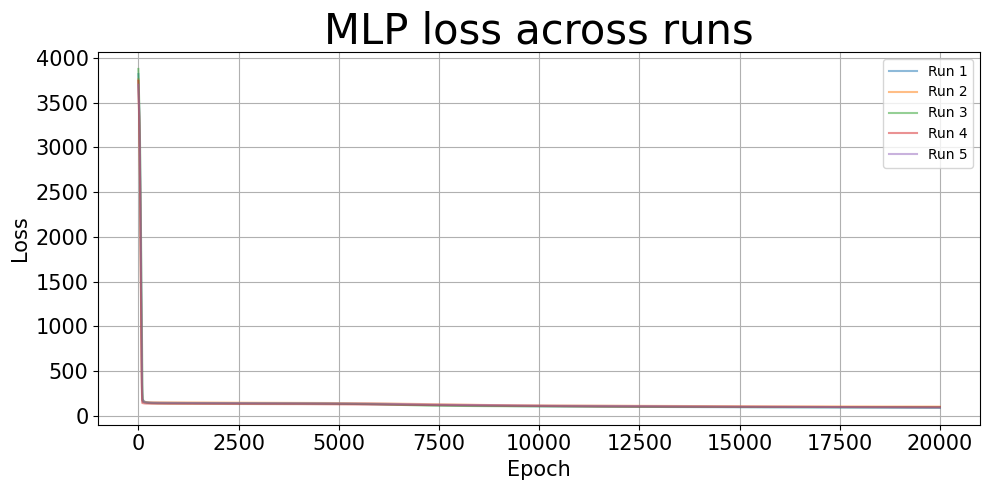

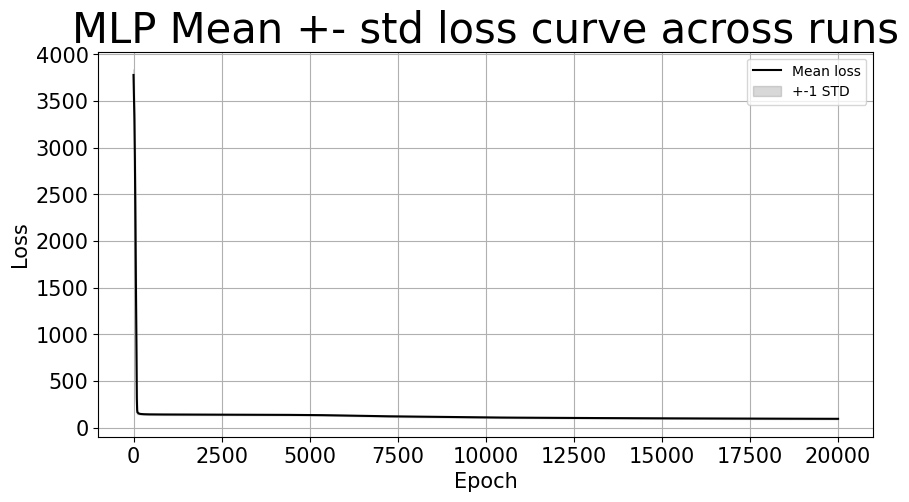

In [5]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and standard deviation of losses over all runs
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(20000), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP Mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()

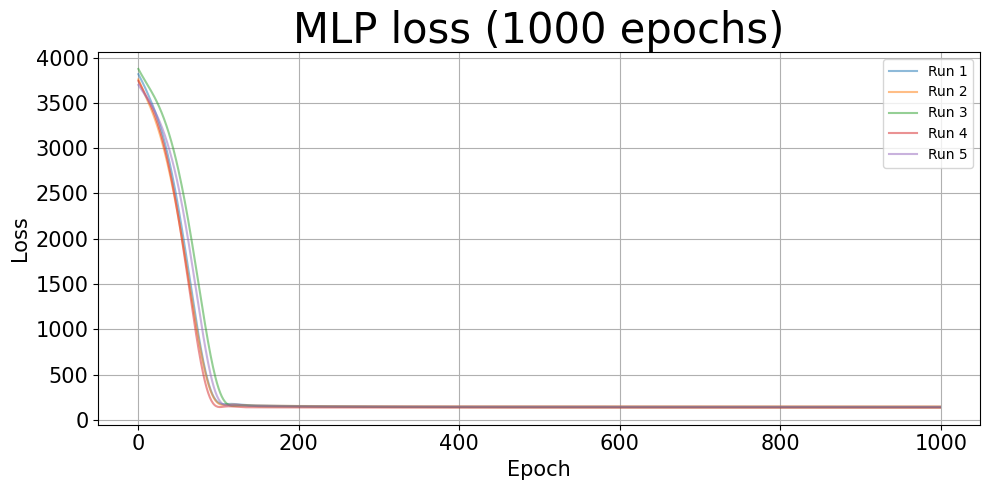

In [6]:
#loss graph restricted to 1000 epochs
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss (1000 epochs)", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

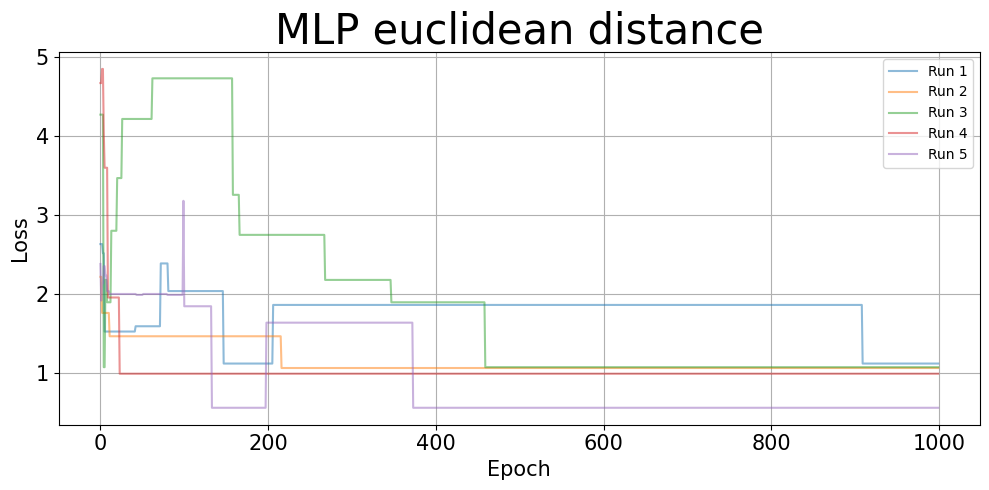

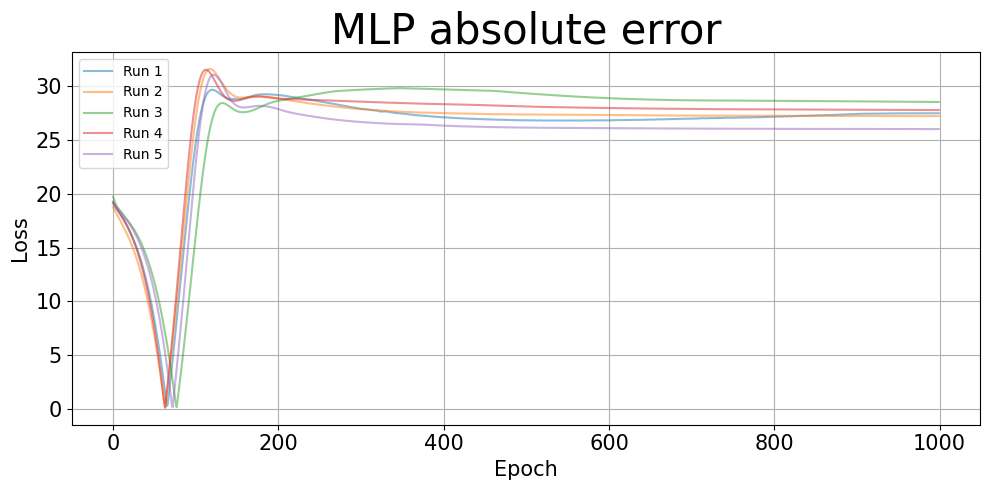

In [7]:
#euclidean distance over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#absolute error over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


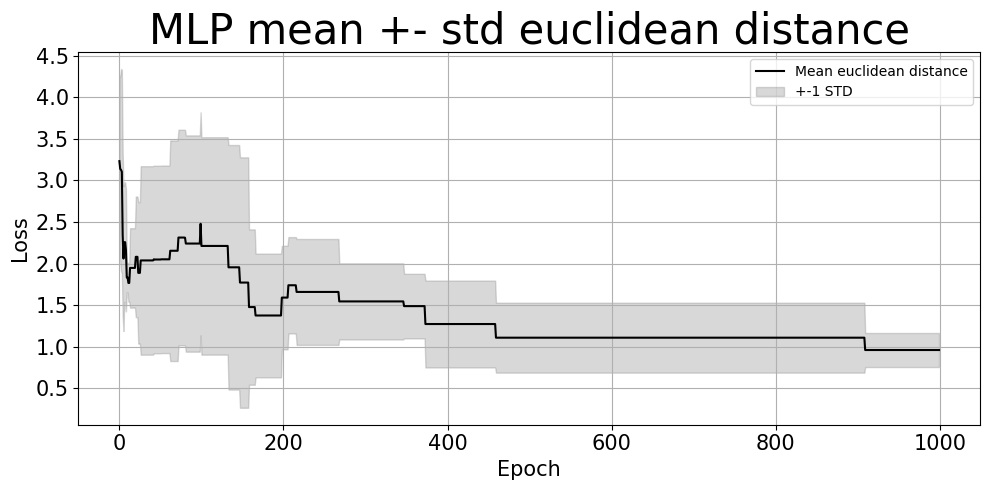

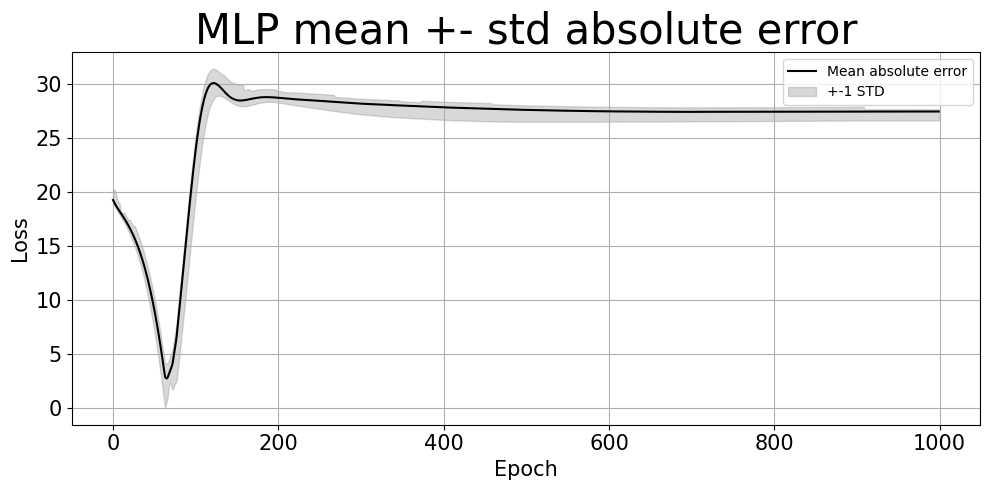

In [8]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
kanNRuns = 5
kanEpochs = 2000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for i in range(kanNRuns):
    torch.manual_seed(i)
    np.random.seed(i)

    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)
    kanModel = KAN(width=[3, 8, 8, 1], grid=50, k=3, seed=i+5)
    optimiser = optim.Adam(kanModel.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    runLosses = []
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []
    startTime = time.time()

    for epoch in range(kanEpochs):
        if epoch == 1000:
            kanModel.refine(100)
        # if epoch == 1000:
        #     kanModel.refine(50)
        # if epoch == 1000:
        #     kanModel.refine(100)     
        kanModel.train()
        optimiser.zero_grad()
        predictions = kanModel(xTrain)
        #loss = torch.mean((predictions - yTrain) ** 2)
        loss = criterion(predictions, yTrain)
        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())

        with torch.no_grad():
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmin(predictions)
            kanBestX = xTrain[bestPrediction]
            kanRunCoordinates.append(kanBestX)
            bestVal = predictions[bestPrediction].item()
            kanBestX1 = kanBestX[0].item()
            kanBestX2 = kanBestX[1].item()
            kanBestX3 = kanBestX[2].item()
            euclideanDistance = torch.norm(torch.tensor([kanBestX1, kanBestX2, kanBestX3]) - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllLosses.append(runLosses)
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestX1,
        "x2": kanBestX2,
        "x3": kanBestX3
    })
    print(f"Run {i+1}: Best x1 = {kanBestX1:.4f}, x2 = {kanBestX2:.4f}, x3 = {kanBestX3:.4f} => Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")

kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]
kanX3Vals = [r["x3"] for r in kanSummary]

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")


checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 1: Best x1 = 2.9135, x2 = 3.1833, x3 = 1.0468 => Objective = 31.1546, Loss = 43.9479
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 2: Best x1 = 3.9374, x2 = 0.9518, x3 = 2.1233 => Objective = 26.3166, Loss = 35.8789
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 3: Best x1 = 0.9035, x2 = 2.9263, x3 = 3.1800 => Objective = 28.3559, Loss = 43.4947
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 4: Best x1 = 2.0346, x2 = 0.9903, x3 = 3.9973 => Objective = 25.0393, Loss = 66.5608
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 5: Best x1 = 2.1244, x2 = 4.0452, x3 = 0.9785 => Objective = 30.0532, Loss = 74.3626
Mean Objective Value: 28.1839 +- 2.2682
Mean Final Loss:      52.8490 +- 14.8699
Mean Time:            214.5795s +-

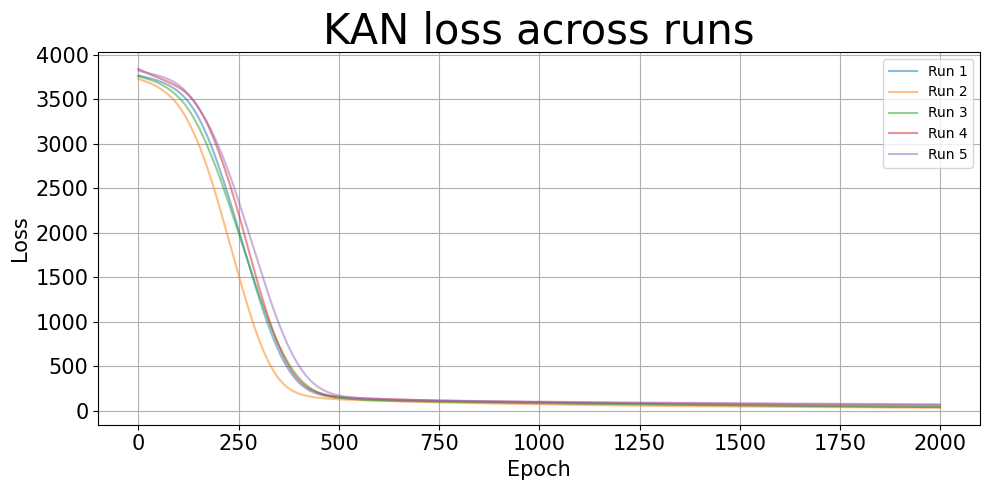

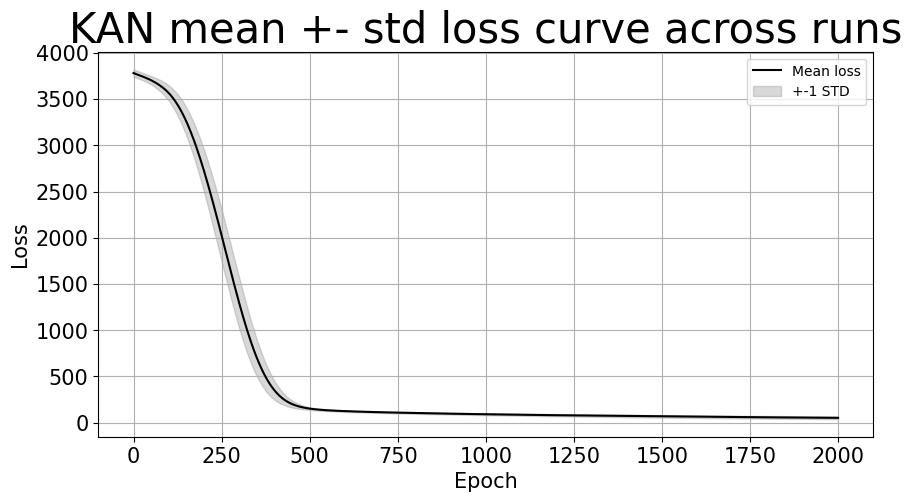

In [10]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#graph of mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(2000), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()



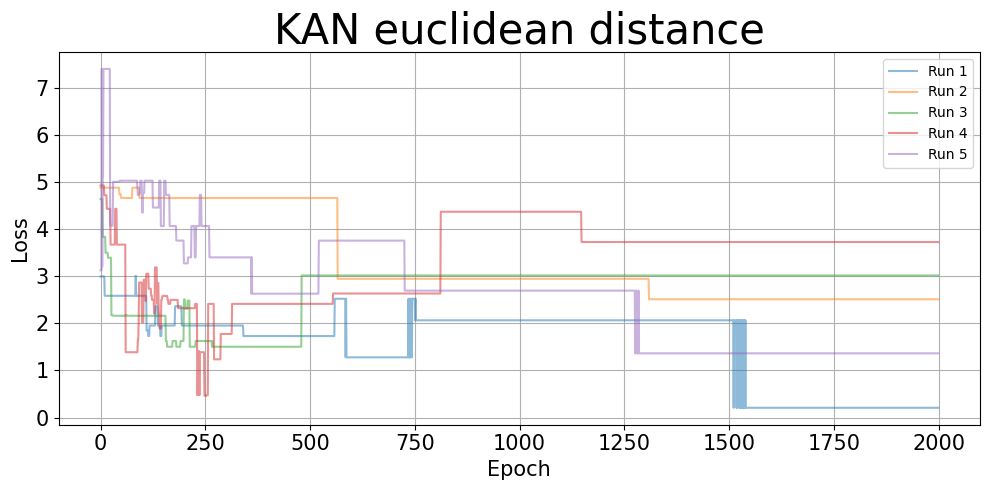

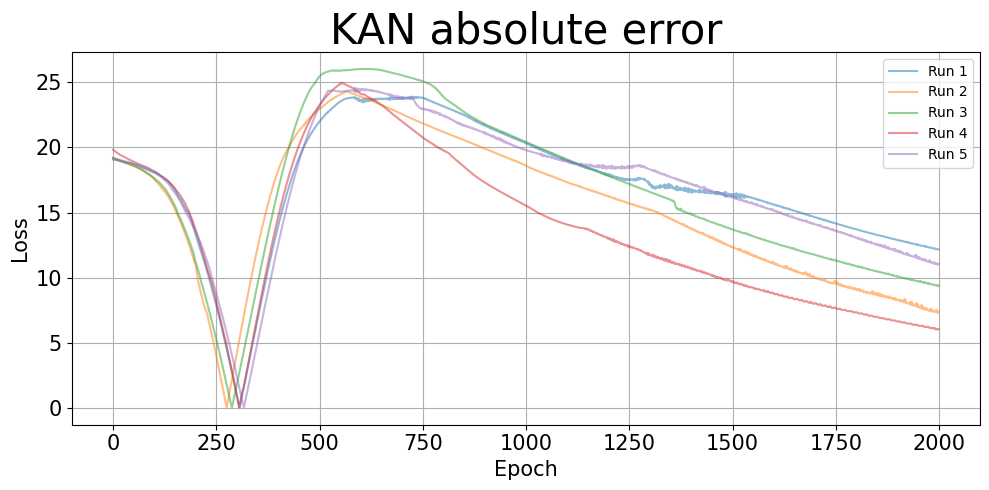

In [11]:
#kan euclidean distance across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#kan absolute error across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



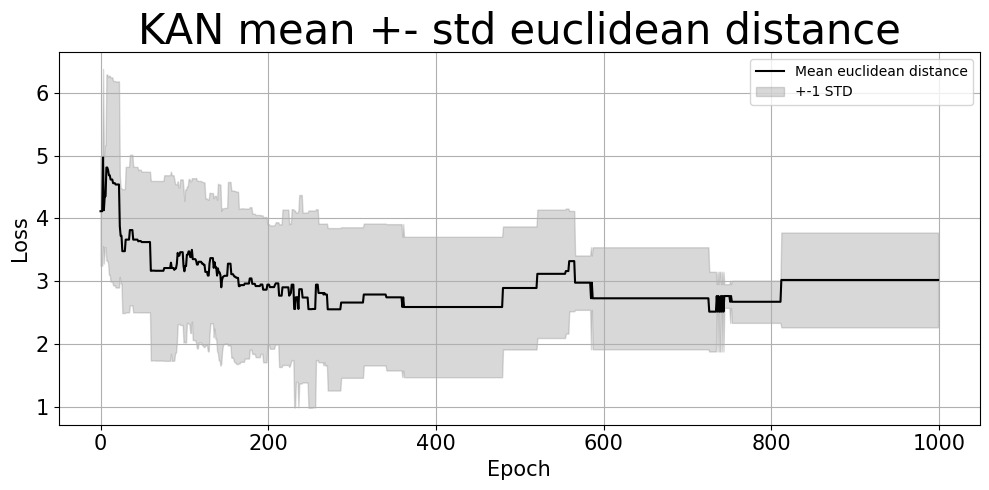

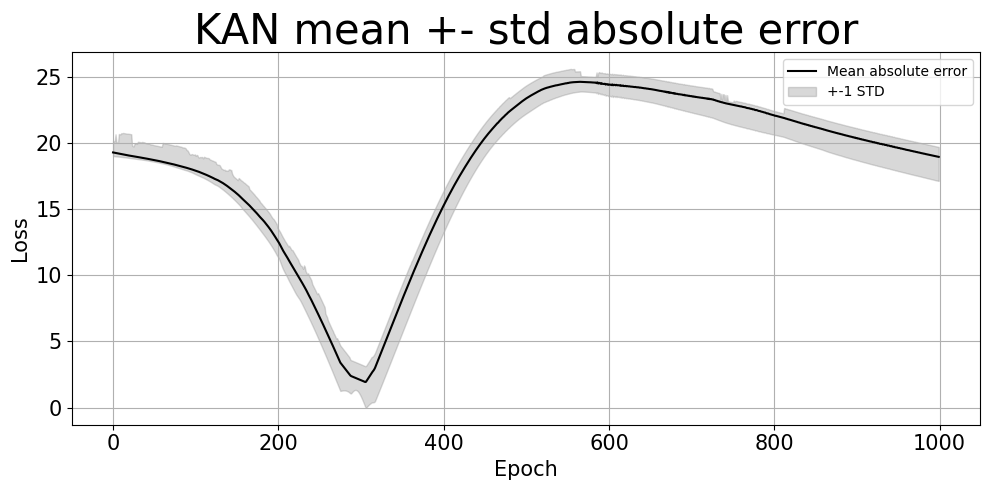

In [12]:
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), kanMeanEuclideanAccuracy[:1000] - kanStdEuclideanAccuracy[:1000], kanMeanEuclideanAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), kanMeanObjectiveAccuracy[:1000] - kanStdObjectiveAccuracy[:1000], kanMeanObjectiveAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [20]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [21]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)


In [22]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,32.522828,28.183926
1,Std Objective Value,3.811510,2.268204
2,Best Objective Value,36.693157,31.154600
3,Mean Final Loss,96.310957,52.848995
4,Std Final Loss,4.334031,14.869892
5,Mean Time (s),60.756313,214.579485
6,Std Time (s),0.678646,82.316157
7,Mean Convergence Epoch,14964.600000,1895.800000
8,Std Convergence Epoch,1345.393712,42.714869
9,Model Parameters,4481.000000,7007.000000


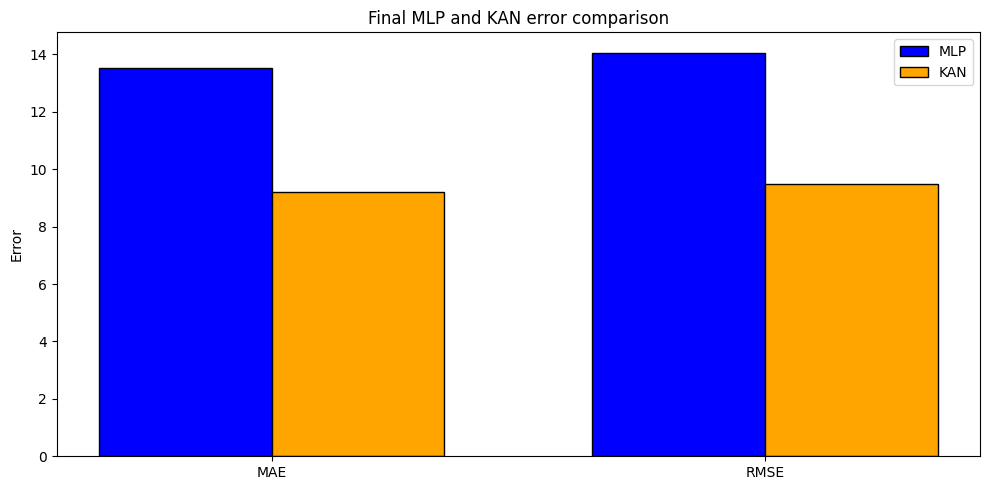

In [13]:
mlpMeanAbsError = abs(np.mean(mlpObjectives) - objAnalytical)
kanMeanAbsError = abs(np.mean(kanObjectives) - objAnalytical)
mlpRMSE = np.sqrt(np.mean((np.array(mlpObjectives) - objAnalytical)**2))
kanRMSE = np.sqrt(np.mean((np.array(kanObjectives) - objAnalytical)**2))

metrics = ['MAE', 'RMSE']
mlpErrors = [mlpMeanAbsError, mlpRMSE]
kanErrors = [kanMeanAbsError, kanRMSE]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mlpErrors, width, label='MLP', color='blue', edgecolor='black')
plt.bar(x + width/2, kanErrors, width, label='KAN', color='orange', edgecolor='black')

plt.ylabel('Error')
plt.title('Final MLP and KAN error comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_21164\2367243651.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


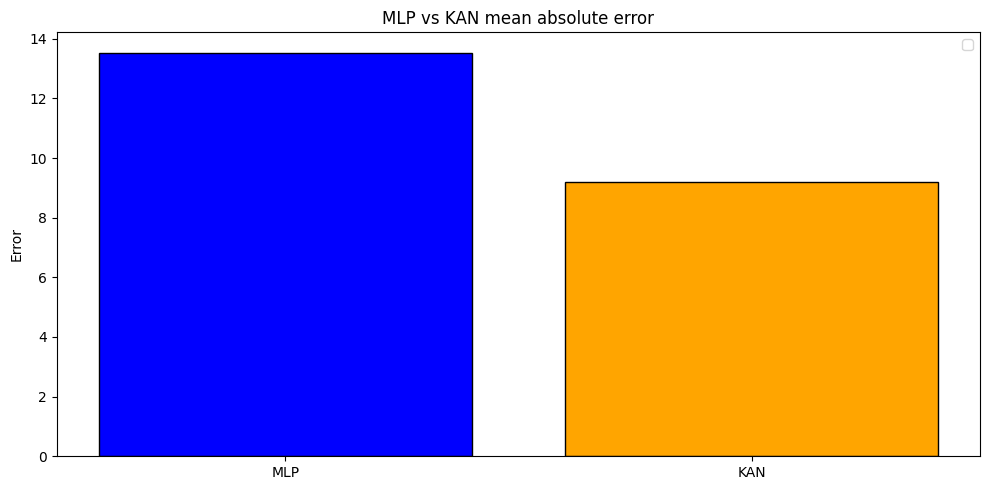

In [14]:
plt.figure(figsize=(10, 5))
plt.bar("MLP", mlpMeanAbsError, color='blue', edgecolor='black')
plt.bar("KAN", kanMeanAbsError, color='orange', edgecolor='black')
plt.ylabel('Error')
plt.title("MLP vs KAN mean absolute error")
plt.legend()
plt.tight_layout()
plt.show()


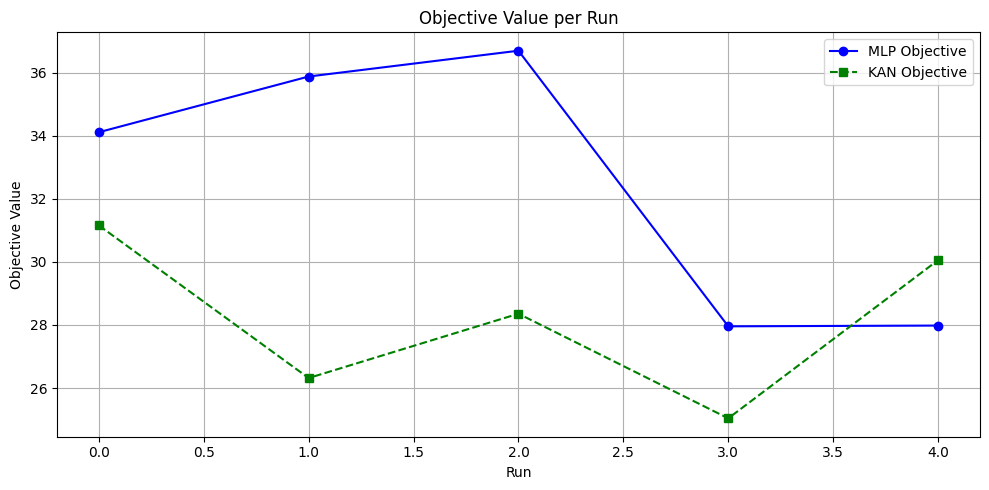

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

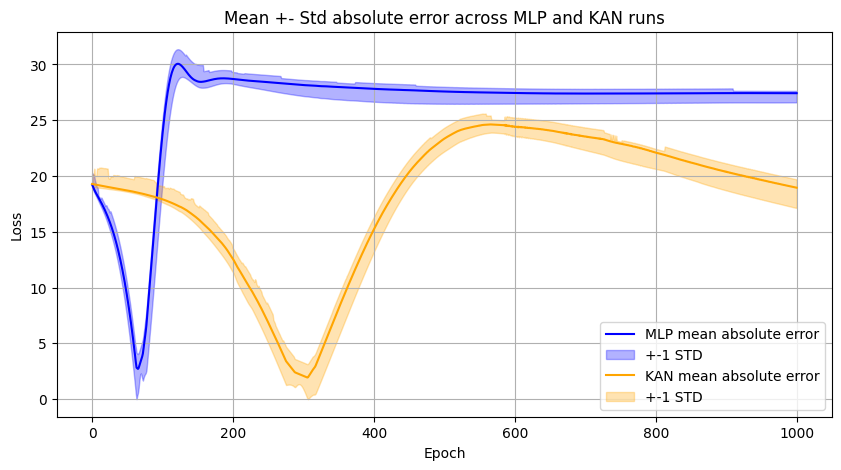

In [15]:
#absolute error comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

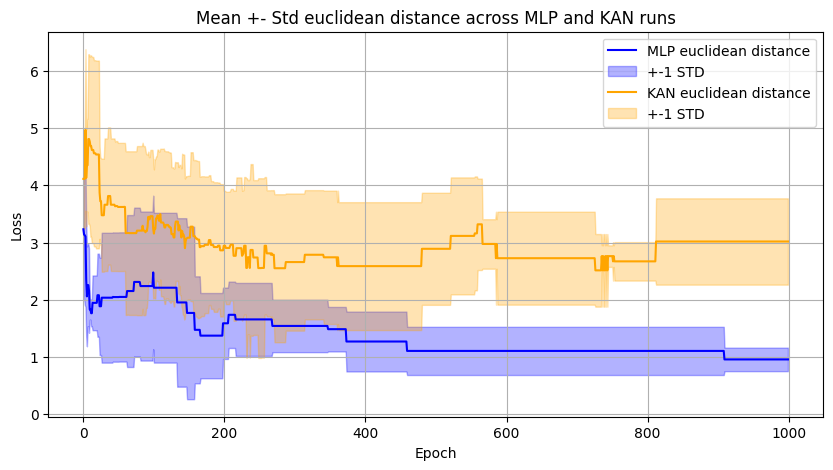

In [16]:
#euclidean distance comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanEuclideanAccuracy[start:epochLimit], label="MLP euclidean distance", color='blue')
plt.fill_between(epochs, mlpMeanEuclideanAccuracy[start:epochLimit] - mlpStdEuclideanAccuracy[start:epochLimit], mlpMeanEuclideanAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanEuclideanAccuracy[start:epochLimit], label="KAN euclidean distance", color='orange')
plt.fill_between(epochs, kanMeanEuclideanAccuracy[start:epochLimit] - kanStdEuclideanAccuracy[start:epochLimit], kanMeanEuclideanAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std euclidean distance across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

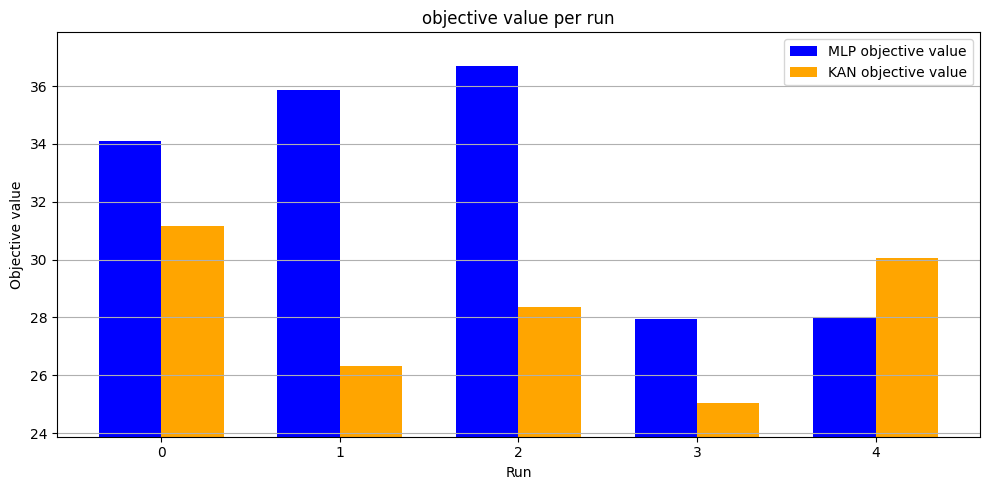

In [17]:
#bar graph of objective values in each run
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP objective value", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN objective value", color='orange')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

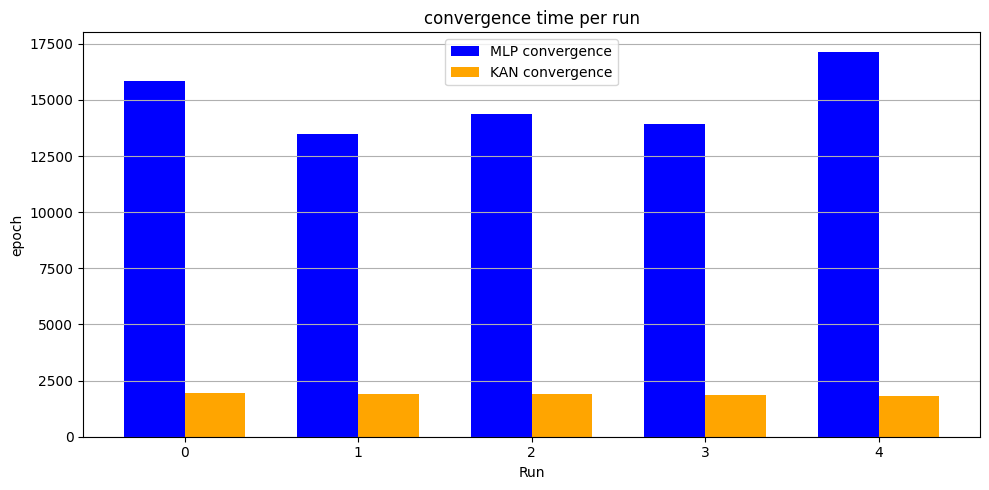

In [27]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

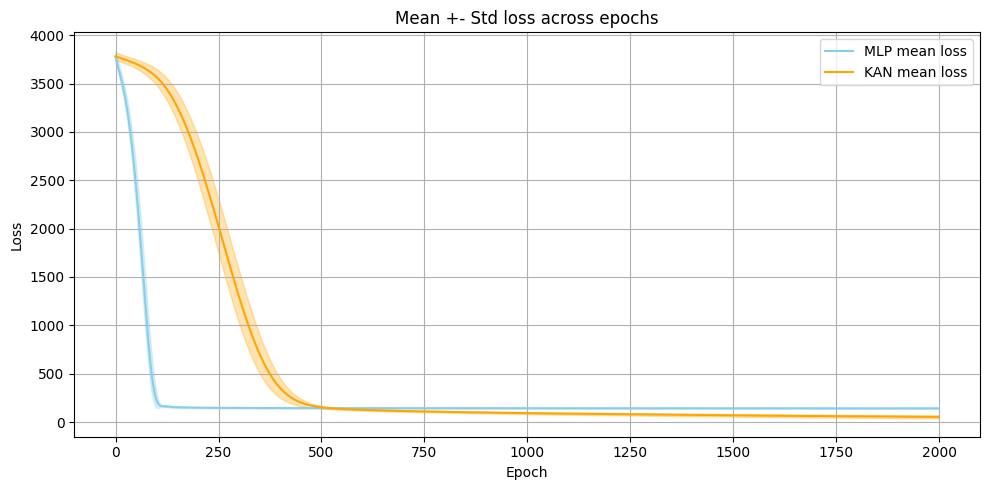

In [19]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:2000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:2000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP mean loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN mean loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std loss across epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


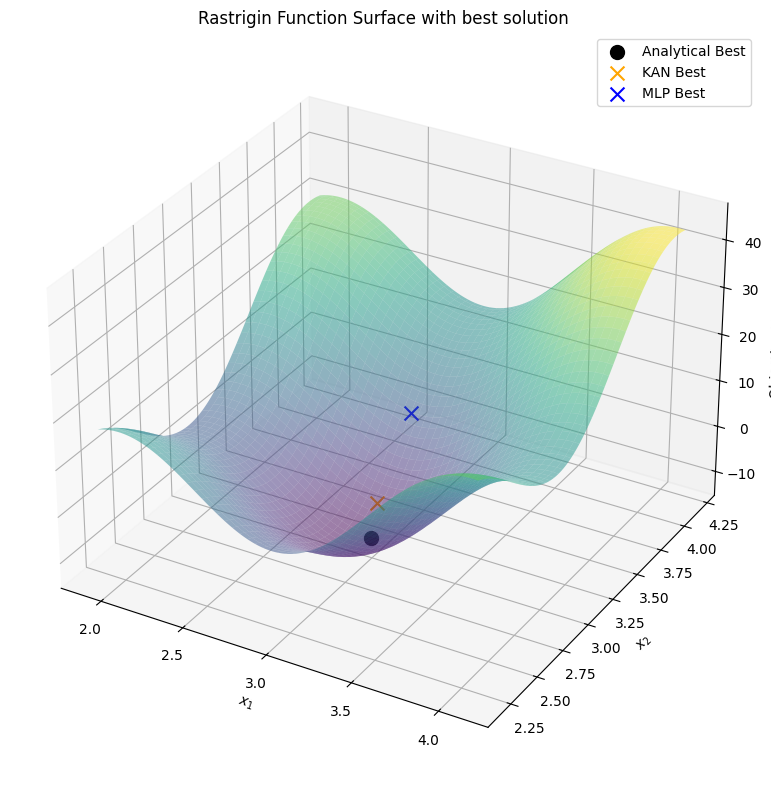

In [60]:
mlpBestX = (mlpX1Vals[np.argmax(mlpObjectives)],
              mlpX2Vals[np.argmax(mlpObjectives)],
              mlpX3Vals[np.argmax(mlpObjectives)])

kanBestX = (kanX1Vals[np.argmax(kanObjectives)],
              kanX2Vals[np.argmax(kanObjectives)],
              kanX3Vals[np.argmax(kanObjectives)])

mlpVal = 10 * (np.cos(np.pi * mlpBestX[0]) +
                    np.cos(np.pi * mlpBestX[1]) +
                    np.cos(np.pi * mlpBestX[2])) + sum(x**2 for x in mlpBestX)

kanVal = 10 * (np.cos(np.pi * kanBestX[0]) +
                    np.cos(np.pi * kanBestX[1]) +
                    np.cos(np.pi * kanBestX[2])) + sum(x**2 for x in kanBestX)

analyticalVal = 10 * (np.cos(np.pi * xAnalytical[0]) +
                    np.cos(np.pi * xAnalytical[1]) +
                    np.cos(np.pi * xAnalytical[2])) + sum(x**2 for x in xAnalytical)

allX1 = [mlpBestX[0], kanBestX[0]]
allX2 = [mlpBestX[1], kanBestX[1]]

x1Min, x1Max = min(allX1) - 1, max(allX1) + 1
x2Min, x2Max = min(allX2) - 1, max(allX2) + 1
x1Vals = np.linspace(x1Min, x1Max, 200)
x2Vals = np.linspace(x2Min, x2Max, 200)
x1Mesh, x2Mesh = np.meshgrid(x1Vals, x2Vals)

x3Fixed = xAnalytical[2]

zVals = (
    10 * (np.cos(np.pi * x1Mesh) + np.cos(np.pi * x2Mesh) + np.cos(np.pi * x3Fixed)) +
    x1Mesh**2 + x2Mesh**2 + x3Fixed**2
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x1Mesh, x2Mesh, zVals, cmap='viridis', alpha=0.5, edgecolor='none')

ax.scatter(*xAnalytical[:2], analyticalVal, color='black', s=100, label='Analytical Best')
ax.scatter(*kanBestX[:2], kanVal, color='orange', marker="x", s=100, label='KAN Best')
ax.scatter(*mlpBestX[:2], mlpVal, color='blue', s=100, marker="x", label='MLP Best')

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("Objective Value")
ax.set_title("Rastrigin Function Surface with best solution")
ax.legend()
ax.view_init(elev=30)
ax.set_box_aspect([1,1,0.7])
plt.tight_layout()
plt.show()
